# getting started with ELA

We will be using data publicly available from the BoM and GA. Ackn, copyrights and the like to be included. 

Aiming to have a 3D grid of primary lithologies.


In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show

import ela

In [98]:
username = os.environ['USER']
data_path = os.path.join('/home', username, 'data')
bungendore_raster = rasterio.open(os.path.join(data_path, 'ela/CLIP.tif'))

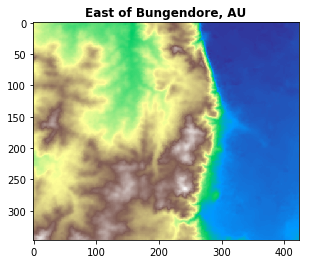

In [3]:
show(bungendore_raster,title='East of Bungendore, AU', cmap='terrain')

In [4]:
# after conda install petl
import petl as etl
bidgee_path = os.path.join(data_path, 'gw_shp_murrumbidgee_river/shp_murrumbidgee_river')
lithology_logs = etl.fromcsv(os.path.join(bidgee_path, 'NGIS_LithologyLog.csv'))

In [5]:
lithology_logs.columns

<bound method columns of +-----------+------------+----------------+----------+-------------+-----------+---------+----------+------------+---------------+---------------+-------------+--------+---------+
| OBJECTID  | BoreID     | HydroCode      | RefElev  | RefElevDesc | FromDepth | ToDepth | TopElev  | BottomElev | MajorLithCode | MinorLithCode | Description | Source | LogType |
+===========+============+================+==========+=============+===========+=========+==========+============+===============+===============+=============+========+=========+
| '3295968' | '10096490' | 'GW403458.1.1' | '332.05' | 'UNK'       | '29.0'    | '30.0'  | '303.05' | '302.05'   | 'None'        | 'NA'          | 'Sump'      | 'UNK'  | '1'     |
+-----------+------------+----------------+----------+-------------+-----------+---------+----------+------------+---------------+---------------+-------------+--------+---------+
| '3295974' | '10117707' | 'GW400023.1.1' | '108.41' | 'UNK'       | '69.0'

In [6]:
lithology_logs = pd.read_csv(os.path.join(bidgee_path, 'NGIS_LithologyLog.csv'))

In [7]:
lithology_logs.head()

,OBJECTID,BoreID,HydroCode,RefElev,RefElevDesc,FromDepth,ToDepth,TopElev,BottomElev,MajorLithCode,MinorLithCode,Description,Source,LogType
0,3295968,10096490,GW403458.1.1,332.05,UNK,29.0,30.0,303.05,302.05,None,NaN,Sump,UNK,1
1,3295974,10117707,GW400023.1.1,108.41,UNK,69.0,71.0,39.41,37.41,None,NaN,NaN,UNK,1
2,3295982,10094368,GW405126.1.1,223.24,UNK,0.0,0.6,223.24,222.64,TPSL,NaN,Topsoil,UNK,1
3,3296095,10113483,GW415991.1.1,None,UNK,0.4,10.0,None,None,CLAY,NaN,Clay,UNK,1
4,3296209,10144702,GW401440.1.1,76.17,UNK,128.0,139.0,-51.83,-62.83,None,NaN,Clay,UNK,1


In [8]:
LITHO_DESC_COL = 'Description'

In [9]:
descs = lithology_logs[LITHO_DESC_COL]
descs = descs.reset_index()
descs = descs[LITHO_DESC_COL]
descs.head()

0       Sump
1        NaN
2    Topsoil
3       Clay
4       Clay
Name: Description, dtype: object

In [10]:
def clean_desc(x):
    if isinstance(x, float):
        return ''
    elif x is None:
        return ''
    else:
        return x

def as_numeric(x):
    if isinstance(x, float):
        return x
    if x == 'None':
        return np.nan
    elif x is None:
        return np.nan
    elif isinstance(x, str):
        return float(x)
    else:
        return float(x)

In [11]:
y = [clean_desc(x) for x in descs]

In [12]:
from striplog import Lexicon
lex = Lexicon.default()
# quite slow: maybe not necessary.
# d = [lex.expand_abbreviations(x) for x in d]

We get a flat list of all the "tokens" but remove stop words ('s', 'the' and the like)

In [13]:
from ela.textproc import *
from ela.utils import *
from ela.classification import *

In [14]:
y = v_lower(y)
vt = v_word_tokenize(y)
flat = np.concatenate(vt)

In [15]:
import nltk
from nltk.corpus import stopwords

In [16]:
stoplist = stopwords.words('english')
exclude = stoplist + ['.',',',';',':','(',')','-']
flat = [word for word in flat if word not in exclude]

In [17]:
len(set(flat))

3154

In [18]:
df_most_common= token_freq(flat, 50)

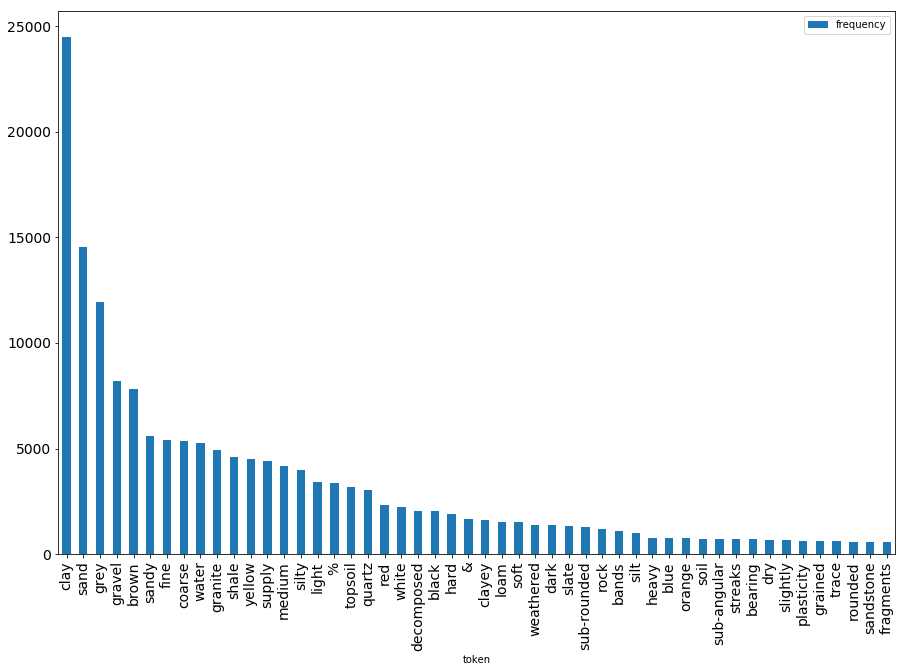

In [19]:
plot_freq(df_most_common)

There are terms such as 'sandy', 'clayey', 'silty' and so on. Let's define functions to detect terms derived from lithology classes, and their frequency. Given the likely skewness, we use a y log scale. 

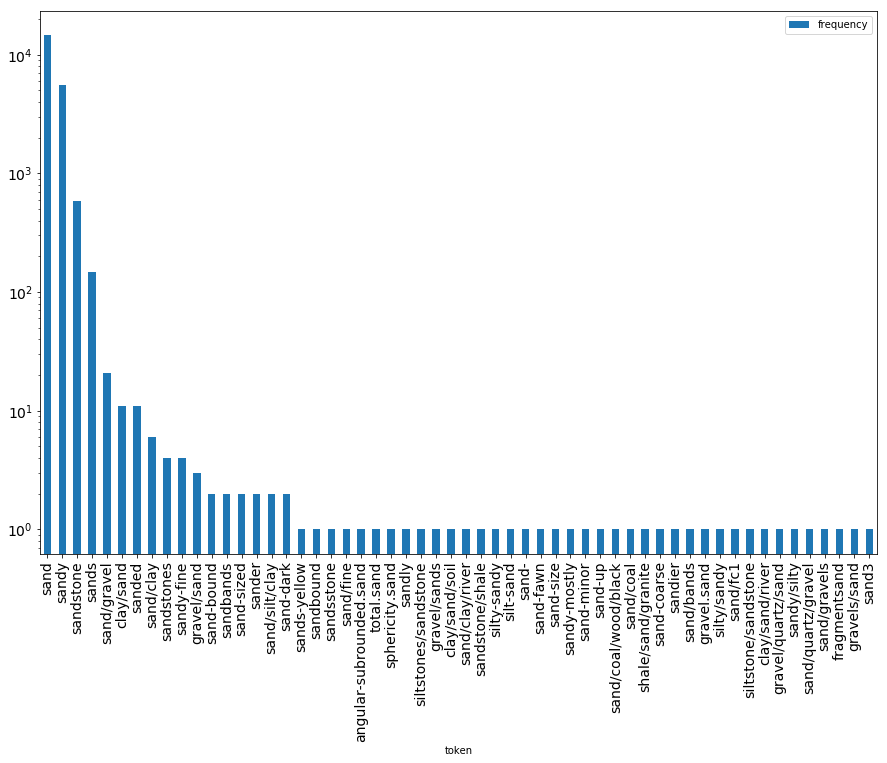

In [20]:
#['sand','sandstone','clay','limestone','shale','basalt','coffee']
plot_freq_for_root(flat, 'sand')

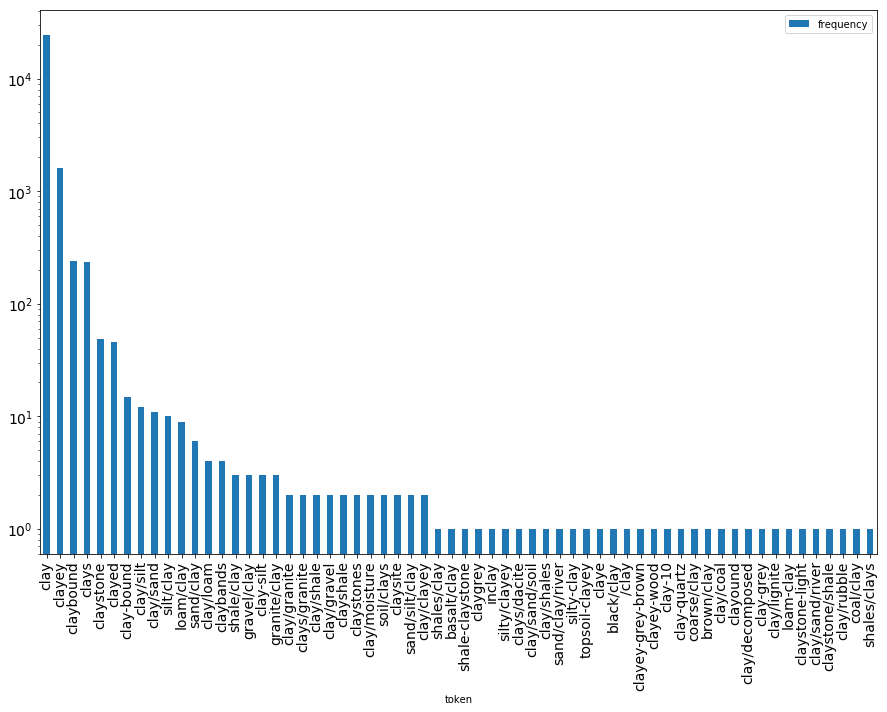

In [21]:
plot_freq_for_root(flat, 'clay')

In [22]:
df_most_common

,token,frequency
0,clay,24501
1,sand,14559
2,grey,11937
3,gravel,8186
4,brown,7837
5,sandy,5591
6,fine,5403
7,coarse,5355
8,water,5249
9,granite,4952


In [23]:
# I leave 'basalt' out, as it was mentioned it may be a mistake in the raw log data.
lithologies = ['clay','sand','gravel','granite','shale','silt','soil','loam','sandstone']

In [24]:
any_litho_markers_re = r'sand|clay|ston|shale|silt|granit|soil|gravel|loam'
regex = re.compile(any_litho_markers_re)

In [25]:
lithologies_dict = dict([(x,x) for x in lithologies])
lithologies_dict['sands'] = 'sand'
lithologies_dict['clays'] = 'clay'
lithologies_dict['shales'] = 'shale'
lithologies_dict['claystone'] = 'clay'
lithologies_dict['siltstone'] = 'silt'
lithologies_dict['limesand'] = 'sand' # ??
lithologies_dict['calcarenite'] = 'limestone' # ??
lithologies_dict['calcitareous'] = 'limestone' # ??
lithologies_dict['mudstone'] = 'silt' # ??
lithologies_dict['capstone'] = 'limestone' # ??
lithologies_dict['ironstone'] = 'sandstone' # ??
lithologies_dict['topsoil'] = 'soil' # ??

In [26]:
lithologies_adjective_dict = {
    'sandy' :  'sand',
    'clayey' :  'clay',
    'clayish' :  'clay',
    'shaley' :  'shale',
    'silty' :  'silt',
    'gravelly' :  'gravel'
}

In [27]:
y[11]

'sand - medium to coarse, yellow brown; quartz sub-angular; feldspar - rounded to sub-rounded, quartz feldspar; fairly well sorted; clay matrix-fine yellow brown; slightly micaceous.'

In [28]:
v_tokens = v_word_tokenize(y)
litho_terms_detected = v_find_litho_markers(v_tokens, regex=regex)

Let's see if we detect these lithology markers in each bore log entries  

In [29]:
zero_mark = [x for x in litho_terms_detected if len(x) == 0 ]
at_least_one_mark = [x for x in litho_terms_detected if len(x) >= 1]
at_least_two_mark = [x for x in litho_terms_detected if len(x) >= 2]
print('There are %s entries with no marker, %s entries with at least one, %s with at least two'%(len(zero_mark),len(at_least_one_mark),len(at_least_two_mark)))

There are 5197 entries with no marker, 53747 entries with at least one, 18827 with at least two


Note: probably need to think of precanned facilities in ela to assess the detection rate in such EDA. Maybe wordcloud not such a bad idea too.

In [30]:
descs_zero_mark = [y[i] for i in range(len(litho_terms_detected)) if len(litho_terms_detected[i]) == 0 ]

In [31]:
descs_zero_mark[1:50]

['',
 'fill',
 'slate water supply',
 'gabbro fresh water supply',
 'slate water supply',
 'rock',
 'gabbro weathered',
 'alluvium water supply',
 'drift salt',
 'blue metal',
 'quartz',
 'slate water supply',
 'floater',
 'porphyry very hard water supply',
 'basalt',
 'slate water supply',
 'slate yellow',
 'slate bedrock',
 'basalt grey fairly hard seams slightly wea water supply',
 'rock hard',
 'slate grey firm water supply quartz thin layers',
 'slate grey firm water supply quartz thin layers',
 'alluvium',
 'slate grey green very hard water supply',
 'alluvium water supply',
 'basalt',
 'slate bars water supply',
 'slate water supply',
 'schist',
 'porphyry water supply',
 'water supply',
 'drift water supply',
 'drift water supply',
 'porphyry decomposed',
 'porphyry very hard water supply',
 'porphyry decomposed water supply',
 'rock hard',
 'slate hard',
 'slate quartz hard bands',
 'porphyry water supply',
 'porphyry',
 'porphyry decomposed',
 'porphyry',
 'slate grey water s

In [32]:
[x for x in zero_mark if len(x) > 0]

[]

In [33]:
bungendore_raster

<open RasterReader name='/home/per202/data/ela/CLIP.tif' mode='r'>

### Round up 'depth to' and 'depth from' columns


We round the depth related columns to the upper integer value and drop the entries where the resulting depths have degenerated to 0

We need to clean up the data since some things that should be numeric are not because of the presence of 'None'

In [34]:
df = lithology_logs

In [35]:
df.head()

,OBJECTID,BoreID,HydroCode,RefElev,RefElevDesc,FromDepth,ToDepth,TopElev,BottomElev,MajorLithCode,MinorLithCode,Description,Source,LogType
0,3295968,10096490,GW403458.1.1,332.05,UNK,29.0,30.0,303.05,302.05,None,NaN,Sump,UNK,1
1,3295974,10117707,GW400023.1.1,108.41,UNK,69.0,71.0,39.41,37.41,None,NaN,NaN,UNK,1
2,3295982,10094368,GW405126.1.1,223.24,UNK,0.0,0.6,223.24,222.64,TPSL,NaN,Topsoil,UNK,1
3,3296095,10113483,GW415991.1.1,None,UNK,0.4,10.0,None,None,CLAY,NaN,Clay,UNK,1
4,3296209,10144702,GW401440.1.1,76.17,UNK,128.0,139.0,-51.83,-62.83,None,NaN,Clay,UNK,1


In [36]:
df.tail()

,OBJECTID,BoreID,HydroCode,RefElev,RefElevDesc,FromDepth,ToDepth,TopElev,BottomElev,MajorLithCode,MinorLithCode,Description,Source,LogType
58939,4177240,10134861,GW600533.1.1,None,UNK,80.0,85.0,None,None,SAND,NaN,Sand,UNK,1
58940,4177815,10134861,GW600533.1.1,None,UNK,9.0,11.0,None,None,SDCY,NaN,Sandy clay,UNK,1
58941,4177816,10134861,GW600533.1.1,None,UNK,24.0,26.0,None,None,SAND,NaN,Sand,UNK,1
58942,4177817,10134861,GW600533.1.1,None,UNK,106.0,108.0,None,None,SILT,NaN,Sand,UNK,1
58943,4181603,10037352,GW010770.1.1,None,UNK,None,None,None,None,UNKN,NaN,None,UNK,1


In [37]:
DEPTH_FROM_COL = 'FromDepth'
DEPTH_TO_COL = 'ToDepth'

In [38]:
TOP_ELEV_COL = 'TopElev'
BOTTOM_ELEV_COL = 'BottomElev'

In [39]:
df[DEPTH_FROM_COL] = df[DEPTH_FROM_COL].apply(as_numeric)
df[DEPTH_TO_COL] = df[DEPTH_TO_COL].apply(as_numeric)
df[TOP_ELEV_COL] = df[TOP_ELEV_COL].apply(as_numeric)
df[BOTTOM_ELEV_COL] = df[BOTTOM_ELEV_COL].apply(as_numeric)

In [40]:
df.isna().sum()

OBJECTID             0
BoreID               0
HydroCode            0
RefElev              0
RefElevDesc          0
FromDepth            6
ToDepth              6
TopElev           2469
BottomElev        2469
MajorLithCode        0
MinorLithCode    58944
Description         15
Source               0
LogType              0
dtype: int64

Curious that ~2500 data points do not have their AHD height but their depth. 

While this can be remediated, we should maybe hold off since the domain upon which we will work is small compared to the full spatial extent of the data set. So, let's subset the logs based on spatial locations, to keep only those "nearby" the DEM we have near the locality of Bungendore in this case study.

We can however still do some rounding now.

In [41]:
depth_from_ceiling =df[DEPTH_FROM_COL].apply(np.ceil)
depth_to_ceiling =df[DEPTH_TO_COL].apply(np.ceil)

In [42]:
depth_from_delta = depth_from_ceiling - df[DEPTH_FROM_COL]
depth_to_delta = depth_to_ceiling - df[DEPTH_TO_COL]

In [43]:
df.head()

,OBJECTID,BoreID,HydroCode,RefElev,RefElevDesc,FromDepth,ToDepth,TopElev,BottomElev,MajorLithCode,MinorLithCode,Description,Source,LogType
0,3295968,10096490,GW403458.1.1,332.05,UNK,29.0,30.0,303.05,302.05,None,NaN,Sump,UNK,1
1,3295974,10117707,GW400023.1.1,108.41,UNK,69.0,71.0,39.41,37.41,None,NaN,NaN,UNK,1
2,3295982,10094368,GW405126.1.1,223.24,UNK,0.0,0.6,223.24,222.64,TPSL,NaN,Topsoil,UNK,1
3,3296095,10113483,GW415991.1.1,None,UNK,0.4,10.0,NaN,NaN,CLAY,NaN,Clay,UNK,1
4,3296209,10144702,GW401440.1.1,76.17,UNK,128.0,139.0,-51.83,-62.83,None,NaN,Clay,UNK,1


In [44]:
df[DEPTH_FROM_COL] = depth_from_ceiling
df[DEPTH_TO_COL] = depth_to_ceiling

df[TOP_ELEV_COL] = df[TOP_ELEV_COL] - depth_from_delta
df[BOTTOM_ELEV_COL] = df[BOTTOM_ELEV_COL] - depth_to_delta

In [45]:
df.head()

,OBJECTID,BoreID,HydroCode,RefElev,RefElevDesc,FromDepth,ToDepth,TopElev,BottomElev,MajorLithCode,MinorLithCode,Description,Source,LogType
0,3295968,10096490,GW403458.1.1,332.05,UNK,29.0,30.0,303.05,302.05,None,NaN,Sump,UNK,1
1,3295974,10117707,GW400023.1.1,108.41,UNK,69.0,71.0,39.41,37.41,None,NaN,NaN,UNK,1
2,3295982,10094368,GW405126.1.1,223.24,UNK,0.0,1.0,223.24,222.24,TPSL,NaN,Topsoil,UNK,1
3,3296095,10113483,GW415991.1.1,None,UNK,1.0,10.0,NaN,NaN,CLAY,NaN,Clay,UNK,1
4,3296209,10144702,GW401440.1.1,76.17,UNK,128.0,139.0,-51.83,-62.83,None,NaN,Clay,UNK,1


In [46]:
collapsed = (df[DEPTH_FROM_COL] == df[DEPTH_TO_COL])
collapsed.sum()

3686

In [47]:
df = df[~collapsed]

## Spatial extent

In [48]:
import geopandas as gpd

In [49]:
filename = os.path.join(data_path, 'gw_shp_murrumbidgee_river/shp_bungendore.shp')
shape=gpd.read_file(filename)

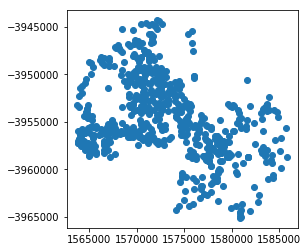

In [50]:
shape.plot()

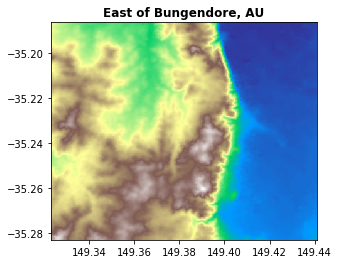

In [51]:
rasterio.plot.show((bungendore_raster, 1), title='East of Bungendore, AU', cmap='terrain')

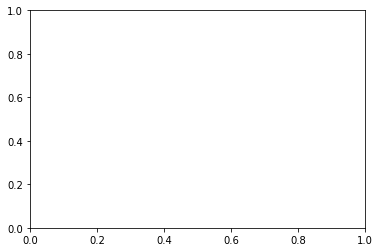

In [52]:
import matplotlib as mpl
ax = mpl.pyplot.gca()

As expected frustrating to do something simple like an overlay in Python (yearning for R's ggmap). Google with keywords "overlay a rasterio with geopandas points".
For future reference perhaps https://geohackweek.github.io/vector/06-geopandas-advanced/  . 

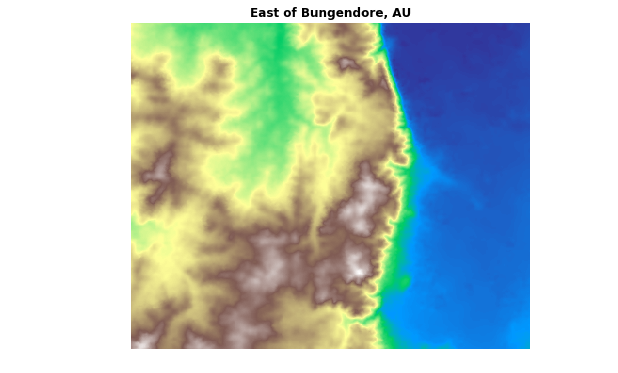

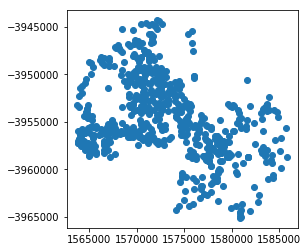

In [53]:
f, ax = plt.subplots(1, figsize=(10, 6))
ax.set_axis_off()
plt.axis('equal')
rasterio.plot.show((bungendore_raster, 1), title='East of Bungendore, AU', cmap='terrain')
shape.plot()
#    column='pfaf_6', markersize=30, 
#                               categorical=True, legend=True, ax=ax);

https://gis.stackexchange.com/questions/294072/how-can-i-superimpose-a-geopandas-dataframe-on-a-raster-plot

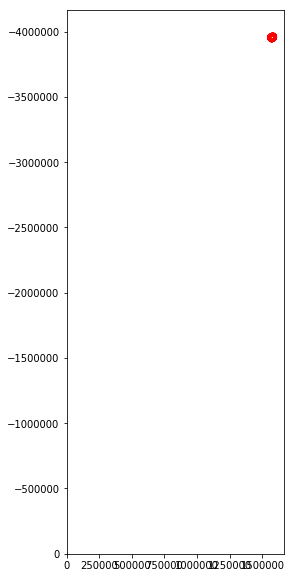

In [58]:
fig, ax = plt.subplots(figsize=(10, 10))
# fig, ax = plt.subplots()
rasterio.plot.show(bungendore_raster, ax=ax)
shape.plot(ax=ax, facecolor='none', edgecolor='red')

In [62]:
bungendore_raster.crs

CRS({'init': 'epsg:4283'})

In [67]:
shape.head()

,HydroID,HydroCode,StateBoreI,StatePipeI,StateTerri,Agency,WCode,BoreDepth,DrilledDep,Status,...,Hydrostrat,WaterLevel,Salinity,WaterCount,WaterDateM,WaterDat_1,SalinityCo,SalinityDa,Salinity_1,geometry
0,10055899,GW061345.1.1,GW061345,1.1,1,1,8,53.3,53.3,UNK,...,0,0,0,0,None,None,0,None,None,POINT (1571118.0099 -3953843.265699999)
1,10094010,GW404937.1.1,GW404937,1.1,1,1,8,96.0,96.0,ABN,...,0,0,0,0,None,None,0,None,None,POINT (1574732.611200001 -3960684.0692)
2,10114667,GW414316.1.1,GW414316,1.1,1,1,8,42.0,42.0,USE,...,0,0,0,0,None,None,0,None,None,POINT (1571721.598499998 -3946581.3848)
3,10114672,GW414581.1.1,GW414581,1.1,1,1,8,42.0,0.0,USE,...,0,0,0,0,None,None,0,None,None,POINT (1572763.126899999 -3955803.617799999)
4,10122533,GW402017.1.1,GW402017,1.1,1,1,8,90.0,90.0,UNK,...,0,0,0,0,None,None,0,None,None,POINT (1570333.1241 -3950451.904899999)


In [66]:
shape.to_crs(epsg=4283).head()

,HydroID,HydroCode,StateBoreI,StatePipeI,StateTerri,Agency,WCode,BoreDepth,DrilledDep,Status,...,Hydrostrat,WaterLevel,Salinity,WaterCount,WaterDateM,WaterDat_1,SalinityCo,SalinityDa,Salinity_1,geometry
0,10055899,GW061345.1.1,GW061345,1.1,1,1,8,53.3,53.3,UNK,...,0,0,0,0,None,None,0,None,None,POINT (149.3489784097488 -35.22371760968667)
1,10094010,GW404937.1.1,GW404937,1.1,1,1,8,96.0,96.0,ABN,...,0,0,0,0,None,None,0,None,None,POINT (149.3986256000393 -35.28027019958979)
2,10114667,GW414316.1.1,GW414316,1.1,1,1,8,42.0,42.0,USE,...,0,0,0,0,None,None,0,None,None,POINT (149.3447418005911 -35.15827840034005)
3,10114672,GW414581.1.1,GW414581,1.1,1,1,8,42.0,0.0,USE,...,0,0,0,0,None,None,0,None,None,POINT (149.3698467002352 -35.23918189993098)
4,10122533,GW402017.1.1,GW402017,1.1,1,1,8,90.0,90.0,UNK,...,0,0,0,0,None,None,0,None,None,POINT (149.3353670295511 -35.19445380035892)


In [70]:
shape_reproj = shape.to_crs(epsg=4283)

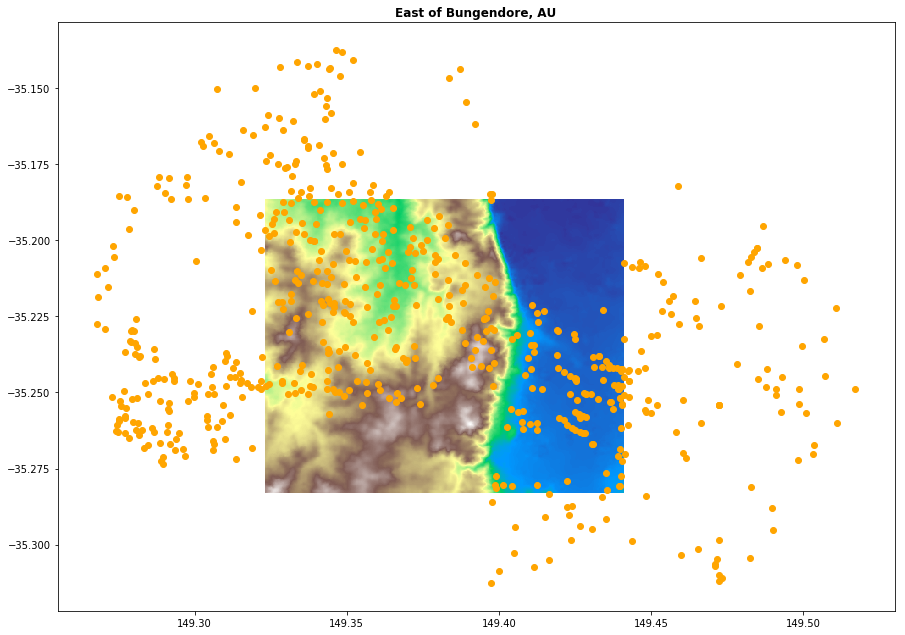

In [76]:
fig, ax = plt.subplots(figsize=(15, 15))
# fig, ax = plt.subplots()
rasterio.plot.show((bungendore_raster, 1), ax=ax, title='East of Bungendore, AU', cmap='terrain')
# shape_reproj.plot(ax=ax, facecolor='none', edgecolor='red')
shape_reproj.plot(ax=ax, facecolor='orange')

### Plot bore log locations

Trying to reproject the raster to the CRS used by the shapefile, to try to have the easting/northing, adapting https://www.earthdatascience.org/courses/earth-analytics-python/lidar-raster-data/reproject-raster/, but the reproj operation fails with a criptic GDALWarpOptions error I could not locate help for. 

In [80]:
dem = bungendore_raster.to_crs(shape.crs)

In [81]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [82]:
dst_crs = shape.crs

In [83]:
src = bungendore_raster

In [84]:
transform, width, height = calculate_default_transform(
    src.crs, dst_crs, src.width, src.height, *src.bounds)
kwargs = src.meta.copy()
kwargs.update({
    'crs': dst_crs,
    'transform': transform,
    'width': width,
    'height': height
})

In [95]:
kwargs

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.4028234663852886e+38,
 'width': 436,
 'height': 437,
 'count': 1,
 'crs': {'proj': 'aea',
  'lat_1': -18,
  'lat_2': -36,
  'lat_0': 0,
  'lon_0': 132,
  'x_0': 0,
  'y_0': 0,
  'ellps': 'GRS80',
  'units': 'm',
  'no_defs': True},
 'transform': Affine(27.637836795424708, 0.0, 1567907.6243425275,
        0.0, -27.637836795424708, -3949429.062220879),
 'affine': Affine(0.0002777777777822621, 0.0, 149.32319444501974,
        0.0, -0.0002777777777822621, -35.18652777799176)}

In [96]:
outfile = os.path.join(data_path, 'ela/CLIP_reproj.tif')
if not os.path.exists(outfile):
    with rasterio.open(outfile, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)
            

/home/per202/anaconda3/envs/ELA/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3267: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/per202/anaconda3/envs/ELA/lib/python3.6/site-packages/rasterio/warp.py:250: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  if src_transform and guard_transform(src_transform).is_identity:
/home/per202/anaconda3/envs/ELA/lib/python3.6/site-packages/rasterio/warp.py:256: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  src_transform = guard_transform(src_transform).to_gdal()


CPLE_IllegalArg: GDALWarpOptions.Validate(): eWorkingDataType=0 is not a supported value.

In [97]:
dir(Resampling)

['__class__',
 '__doc__',
 '__members__',
 '__module__',
 'average',
 'bilinear',
 'cubic',
 'cubic_spline',
 'gauss',
 'lanczos',
 'max',
 'med',
 'min',
 'mode',
 'nearest',
 'q1',
 'q3']

In [99]:
bungendore_raster = rasterio.open(os.path.join(data_path, 'ela/CLIP.tif'))

In [100]:
dem = bungendore_raster

In [101]:
dem.crs

CRS({'init': 'epsg:4283'})

We extract a portion of the dem over the bounding box of the groundwater areas of interest, and save DEM data as numpy arrays that will be more convenient to work with in mayavi (with x=easting and y=northing) 

In [77]:
# max/min bounds
x_min=shape_reproj.total_bounds[0]
y_min=shape_reproj.total_bounds[1]
x_max=shape_reproj.total_bounds[2]
y_max=shape_reproj.total_bounds[3]
(x_min, x_max, y_min, y_max)

(149.26790845002319, 149.517031719996, -35.31259268040253, -35.137606299859556)

In [78]:
(x_max-x_min, y_max-y_min)

(0.24912326997281298, 0.17498638054297544)

In [ ]:
m = create_meshgrid(gw_subareas, 100)

In [ ]:
[x.shape for x in m]

In [ ]:
# StamenTerrain doc says 'Terrain tiles defined for the continental United States' ===> Huh?
stamen_terrain = cimgt.StamenTerrain()